In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pylab as plt
from scipy.io import wavfile
import sklearn
from glob import glob 
from itertools import cycle
import librosa 
import librosa.display 
import IPython.display as ipd
sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])


# Exploritory data analysis 

I denne notebooken skal den innsamlede dataen bli presenter, analysert og modifisert slik at vi får en god forståelse av hvilke egenskaper vår data har. Notebooken er delt opp i følgende seksjoner:
1. Presentasjon av ulike datatyper
2. Dataforståelse 
3. Features 
4. Analyse
5. Konklusjon


## Presentasjon av data
I denne notebooken kommer vi å jobbe med 4 typer kjøretøy og deres tilhørende lyddata. Vi har 
* Bil
* Moped 
* Bus 
* Metrobus

Vi jobber kun med lyddata, dvs. at vi ikke har noen annen informasjon tilgjengelig enn lyden (i utgangspunktet). 

Første delen av analyse vil basere seg på det første lydopptaket vi gjorde. Her har vi også en video som gjør at vi kan lable kjøretøyene manuelt. Vi starter med å hente ut de respektive lydfilene ved bruk av Librosa. Hver lydfil varer i 5 sekunder. Det er verdt å nevne at mopeden passerte samtiding som bil i motgående kjøreretning og bussene kjørte rett etter hverandre. 
Deretter plotter vi lydbølgen til hver av de fire kjøretøyene. 

In [2]:
def average_zero_crossing(sounds):
    if len(sounds)==1:
        sound, sr = librosa.load(sounds[0])
        return sum(librosa.zero_crossings(sound, pad=False))
    zero_crossing = 0
    for i in range(len(sounds)-1):
        tmp, sr = librosa.load(sounds[i])
        zero_crossing += (sum(librosa.zero_crossings(tmp, pad=False)))
       
    return zero_crossing//len(sounds)

In [3]:
big = glob('../input/vehicle/big/*.wav')
medium = glob('../input/vehicle/medium/*.wav')
small = glob('../input/vehicle/small/*.wav')

print("medium: " , average_zero_crossing(medium))
print("large: ", average_zero_crossing(big))
print("small: ", average_zero_crossing(small))

medium:  3026
large:  8540
small:  2653


In [4]:
empty, srEmpty = librosa.load('../input/initcarsound/audio_13092022.WAV', offset=28, duration=5)
car, srCar = librosa.load('../input/initcarsound/audio_13092022.WAV', offset=46, duration=5)
moped, srMoped = librosa.load('../input/initcarsound/audio_13092022.WAV', offset=130, duration=5)
bus, srBus = librosa.load('../input/initcarsound/audio_13092022.WAV', offset=218, duration=5)
metroBus, srMetroBus = librosa.load('../input/initcarsound/audio_13092022.WAV', offset=223, duration=5)
car[1:50]

array([ 0.00776073,  0.00591684, -0.00453037, -0.01531299, -0.01473659,
       -0.00544505,  0.00324429,  0.00898352,  0.00982459,  0.01473139,
        0.01771459,  0.01123207,  0.00564684, -0.00182325, -0.00652918,
       -0.00521462, -0.00678144, -0.0066033 ,  0.00216672,  0.00845232,
        0.00425858,  0.00416373,  0.0062766 ,  0.00199847, -0.00419808,
       -0.00545189, -0.00488412, -0.00986457, -0.0120066 , -0.01184217,
       -0.01091939, -0.00527342,  0.00058994,  0.00280036, -0.0016035 ,
       -0.002908  ,  0.00201707, -0.00135425, -0.00810792, -0.00847275,
       -0.00847337, -0.01223088, -0.0170264 , -0.0158779 , -0.01079202,
       -0.00866331, -0.0070498 , -0.00645149, -0.00156367], dtype=float32)

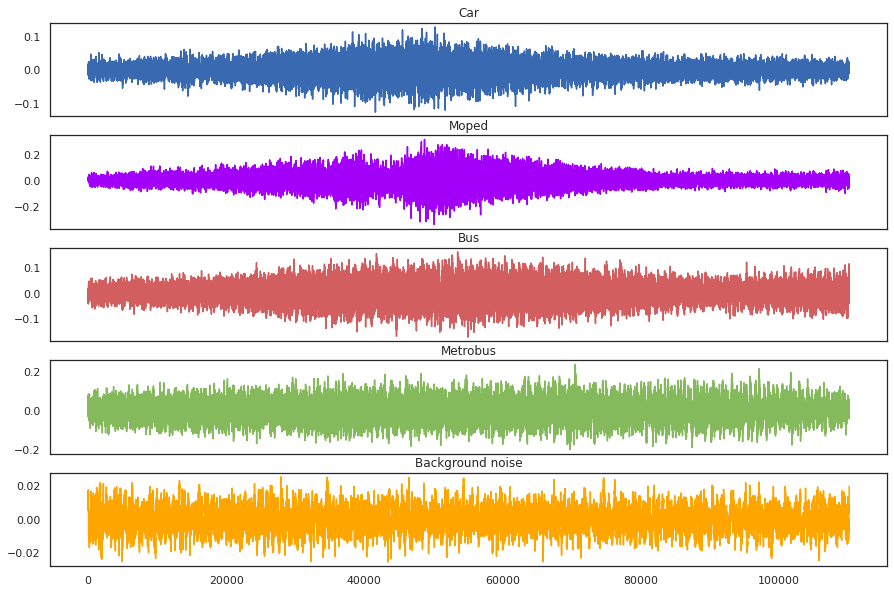

In [5]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex=True, figsize=(15,10))
ax1.plot(car, color ='#396AB1')
ax1.title.set_text("Car")
ax2.plot(moped, color="#A300F9")
ax2.title.set_text("Moped")
ax3.plot(bus, color="#D35E60")
ax3.title.set_text("Bus")
ax4.plot(metroBus, color = "#84BA5B")
ax4.title.set_text("Metrobus")
ax5.plot(empty, color="orange")
ax5.title.set_text("Background noise")

Som vi ser av lydbølgene er støyen ca 0.025. Det gjør at vi kan prøve å filtrere bort all lyd som er lavere enn dette. Denne grensen kan man prøve seg frem med, man vil ikke ha med unødvendig lyd, men man kan gå glipp av viktig informasjon hvis man klipper bort for mye. 

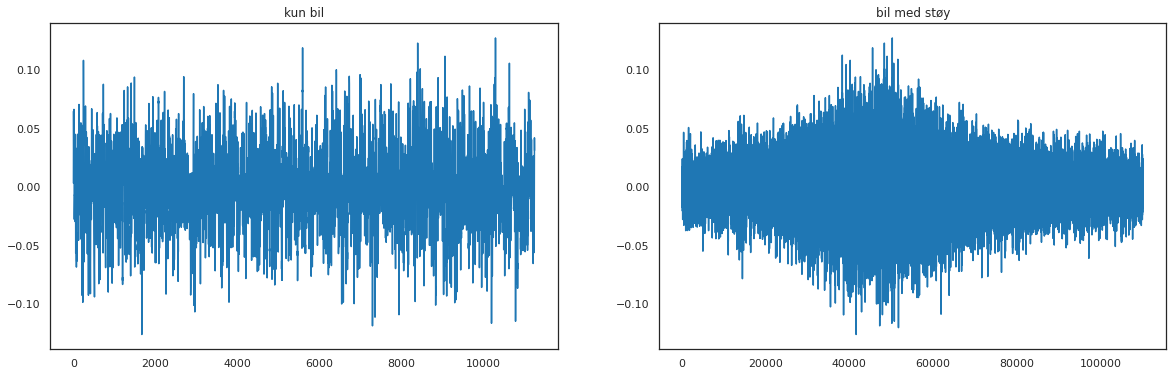

In [6]:
noise_limit = 1
car_trimmed, _ = librosa.effects.trim(car, top_db=noise_limit)
fig, (ax1, ax2) = plt.subplots(1,2,  figsize=(20,6))
ax1.plot(car_trimmed)
ax1.title.set_text("kun bil")
ax2.plot(car)
ax2.title.set_text("bil med støy")

Ved å fjerne lyden foran og bak som ikke overstiger støygrensens, sitter vi igjen med en mindre lydfil. Denne lydfilen inneholder forhåpentligvis all nødvendig data vi trenger, men inntil videre jobber vi både med den komplette lydfilen og den avkuttede.  Vi gjør det samme med de andre lydfilene. Vi kan se at vi får ganske ulike lydbølger for hvert kjøretøy.


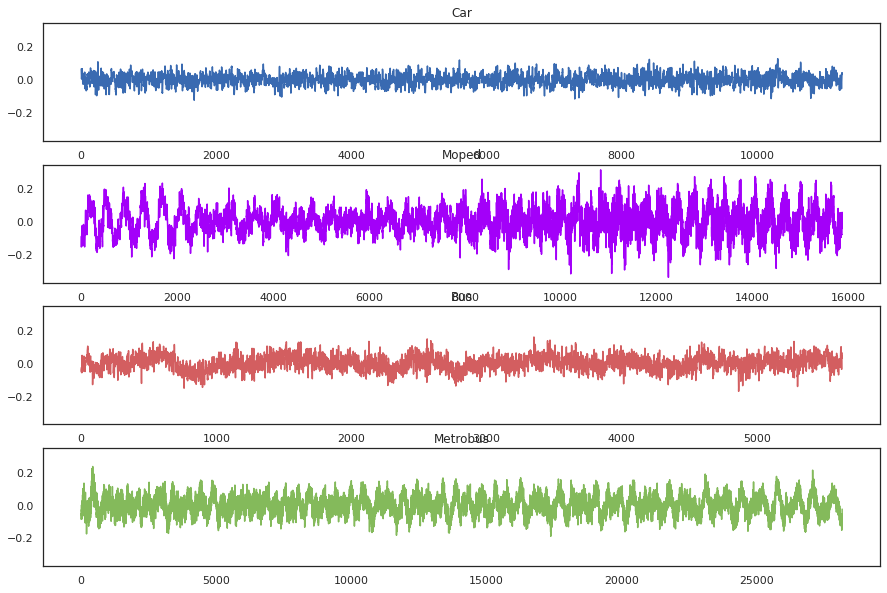

In [7]:
moped_trimmed, _ = librosa.effects.trim(moped, top_db=noise_limit)
bus_trimmed, _ = librosa.effects.trim(bus, top_db=noise_limit)
metrobus_trimmed, _ = librosa.effects.trim(metroBus, top_db=noise_limit)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=False, sharey=True, figsize=(15,10))
ax1.plot(car_trimmed, color ='#396AB1')
ax1.title.set_text("Car")
ax2.plot(moped_trimmed, color="#A300F9")
ax2.title.set_text("Moped")
ax3.plot(bus_trimmed, color="#D35E60")
ax3.title.set_text("Bus")
ax4.plot(metrobus_trimmed, color = "#84BA5B")
ax4.title.set_text("Metrobus")


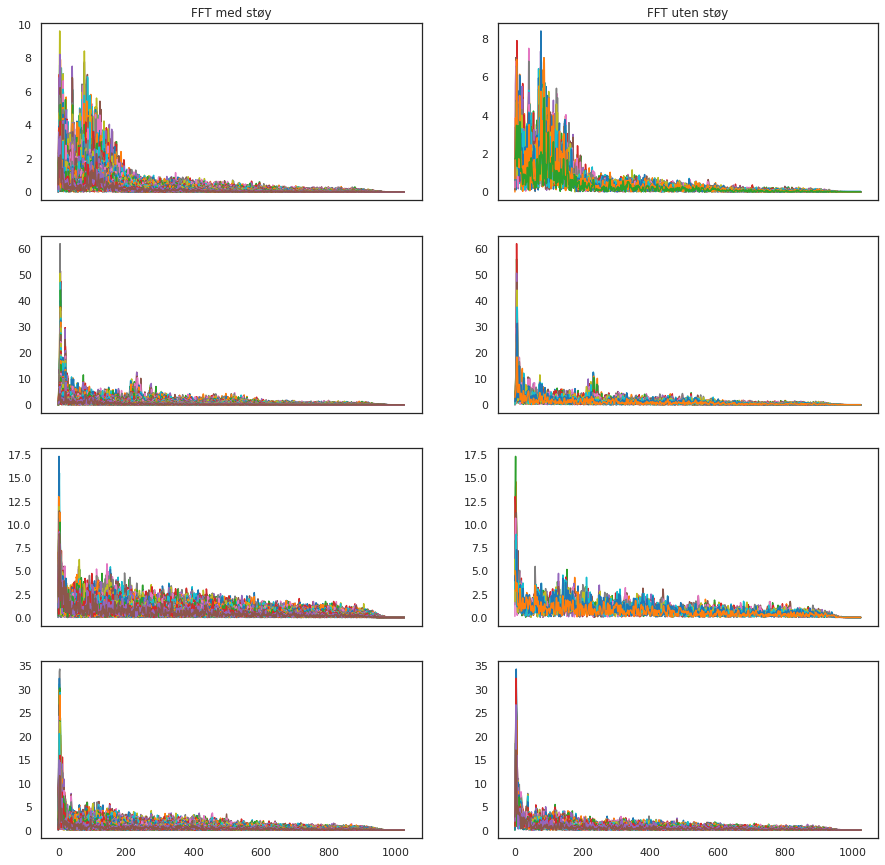

In [8]:
n_fft = 2048 # FFT window size
hop_length = 512

#FFT på fult lydsignal
car_fft = np.abs(librosa.stft(y=car, n_fft=n_fft, hop_length=hop_length, window='hann'))
moped_fft = np.abs(librosa.stft(y=moped, n_fft=n_fft, hop_length=hop_length, window='hann'))
bus_fft = np.abs(librosa.stft(y=bus, n_fft=n_fft, hop_length=hop_length, window='hann'))
metrobus_fft = np.abs(librosa.stft(y=metroBus, n_fft=n_fft, hop_length=hop_length, window='hann'))

#FFT på støyfiltrert lydsignal
car_trim_fft = np.abs(librosa.stft(y=car_trimmed, n_fft=n_fft, hop_length=hop_length, window='hann'))
moped_trim_fft = np.abs(librosa.stft(y=moped_trimmed, n_fft=n_fft, hop_length=hop_length, window='hann'))
bus_trim_fft = np.abs(librosa.stft(y=bus_trimmed, n_fft=n_fft, hop_length=hop_length, window='hann'))
metrobus_trim_fft = np.abs(librosa.stft(y=metrobus_trimmed, n_fft=n_fft, hop_length=hop_length, window='hann'))
fig, axes = plt.subplots(4,2, sharex=True, figsize=(15,15))


axes[0][0].plot(car_fft);
axes[1][0].plot(moped_fft);
axes[2][0].plot(bus_fft);
axes[3][0].plot(metrobus_fft);

axes[0][1].plot(car_trim_fft);
axes[1][1].plot(moped_trim_fft);
axes[2][1].plot(bus_trim_fft);
axes[3][1].plot(metrobus_trim_fft);
axes[0][0].title.set_text("FFT med støy")
axes[0][1].title.set_text("FFT uten støy")

## Features 

Etter å ha visualisert lyden og sett på ulikhetene mellom du forskjellige kjøretøyene skal vi nå prøve å tilegne hvert lydklipp noen features, altså egenskaper som kan være nyttig i maskinlæring. Følgende features skal bli analysert:
* Zero crossing rate
* Spectral Centroid

Det første vi gjør er å putte lydfilen i en pandas dataframe. 


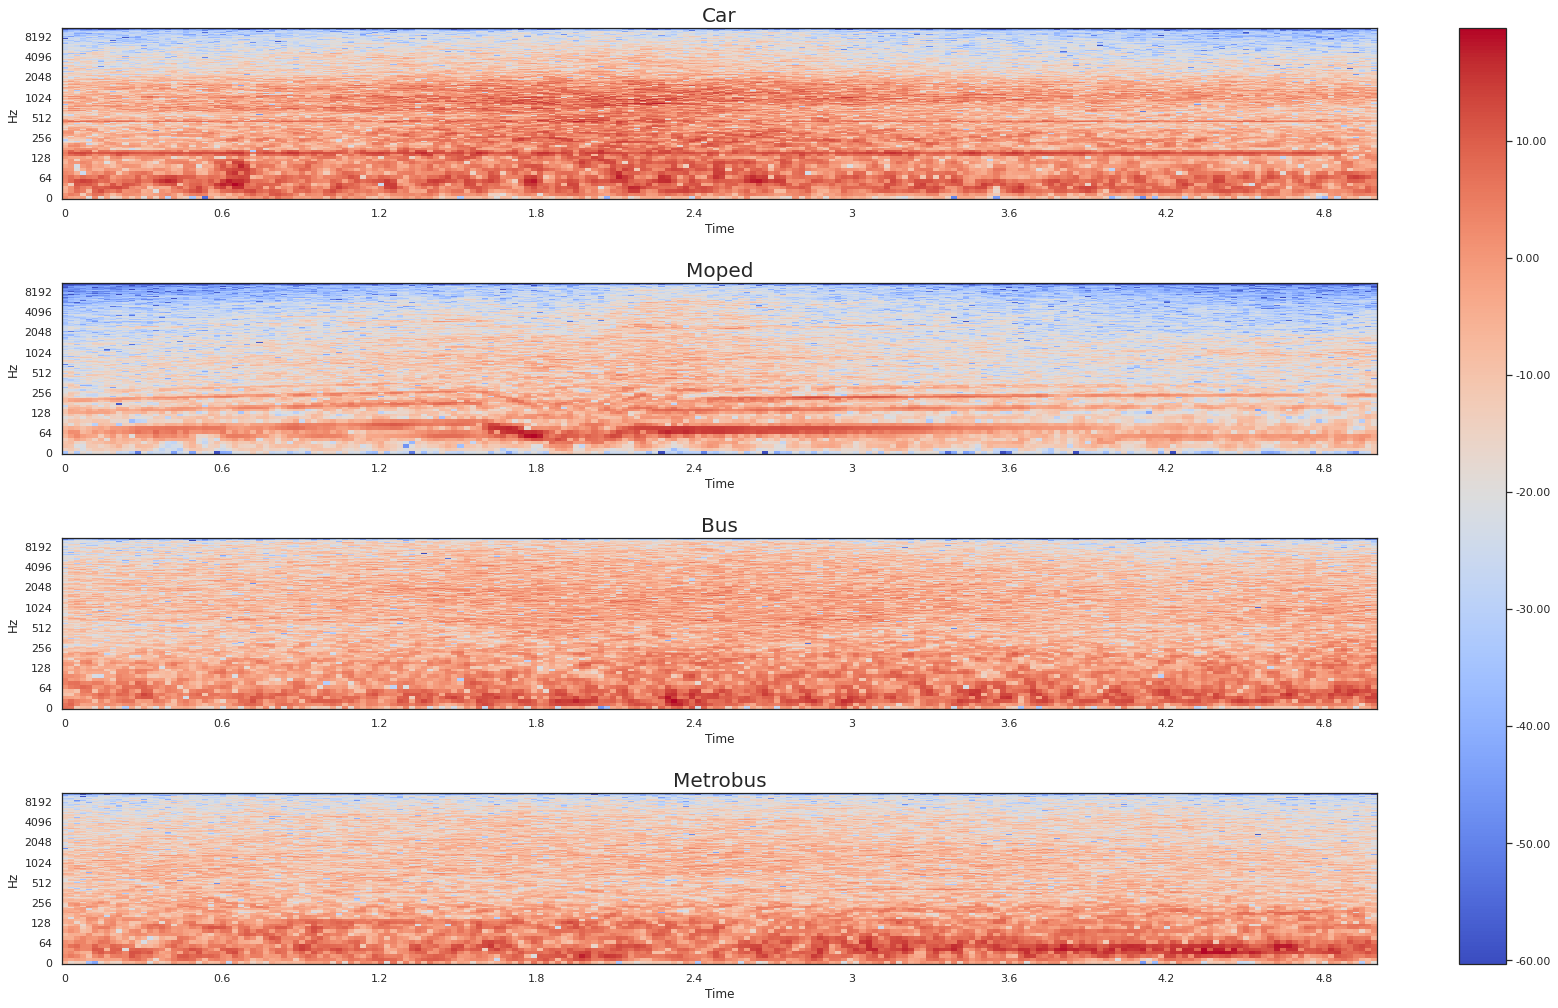

In [9]:
# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
fig3, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(25,15))
fig3.tight_layout(pad=5.0)
DS_car = librosa.amplitude_to_db(np.abs(car_fft))
DS_moped = librosa.amplitude_to_db(np.abs(moped_fft))
DS_bus = librosa.amplitude_to_db(np.abs(bus_fft))
DS_metrobus = librosa.amplitude_to_db(np.abs(metrobus_fft))



car_spec = librosa.display.specshow(DS_car,
                              x_axis='time',
                              y_axis='log',
                              ax=ax1)
moped_spec = librosa.display.specshow(DS_moped,
                              x_axis='time',
                              y_axis='log',
                              ax=ax2)
bus_spec = librosa.display.specshow(DS_bus,
                              x_axis='time',
                              y_axis='log',
                              ax=ax3)
metrobus_spec = librosa.display.specshow(DS_metrobus,
                              x_axis='time',
                              y_axis='log',
                              ax=ax4)
ax1.set_title('Car', fontsize=20)
ax2.set_title('Moped', fontsize=20)
ax3.set_title('Bus', fontsize=20)
ax4.set_title('Metrobus', fontsize=20)
fig3.colorbar(car_spec, ax=[ax1,ax2,ax3,ax4], format=f'%0.2f')
plt.show()

In [10]:
sound_samples = [car, moped, bus, metroBus]
types = ["car", "moped", "bus", "metrobus"]
df = pd.DataFrame(sound_samples)
df["labels"] = types
df.head()

,0,1,2,3,4,5,6,7,8,9,...,110241,110242,110243,110244,110245,110246,110247,110248,110249,labels
0,0.002269,0.007761,0.005917,-0.004530,-0.015313,-0.014737,-0.005445,0.003244,0.008984,0.009825,...,-0.003463,-0.003017,-0.003582,-0.001735,0.004905,0.013137,0.013347,0.014112,0.019432,car
1,-0.000545,0.001076,-0.002483,0.001886,0.017237,0.023712,0.025576,0.019868,0.012965,0.010914,...,-0.047225,-0.037362,-0.018813,-0.013127,-0.009699,-0.001190,0.013485,0.016078,0.014006,moped
2,-0.015480,-0.024071,-0.015156,-0.019284,-0.025071,-0.029414,-0.030940,-0.028147,-0.020120,-0.014735,...,0.062465,0.050691,0.012253,0.013887,0.059986,0.066373,0.031844,0.017238,0.002110,bus
3,0.014493,0.032388,-0.024657,-0.033562,0.000509,0.048108,0.064927,0.005393,0.016554,0.038503,...,-0.016975,-0.003035,-0.009757,-0.016219,-0.017365,-0.033121,-0.032161,-0.031993,-0.009979,metrobus


### Zero crossing rate
ZCR gir oss antall ganger lydsignalet går fra positiv til negativ og omvendt.

In [11]:
zero_crossing_rates=[]
for sound in sound_samples:
    zero_crossing_rates.append(sum(librosa.zero_crossings(sound, pad=False)))

df["Zero Crossing Rate"] = zero_crossing_rates
df_no_sound  = df[['labels','Zero Crossing Rate']]
df_no_sound.head()

,labels,Zero Crossing Rate
0,car,11800
1,moped,13569
2,bus,28673
3,metrobus,19903


### Spectral Centroid

Spectral Centroid inidkierer hvor massesenteret til lyden er plassert. Jo høyere verdi jo lysere er lyden

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Pass y=[0.00226865 0.00776073 0.00591684 ... 0.01334683 0.01411158 0.01943225] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  """Entry point for launching an IPython kernel.


Spectral shape: (216,)


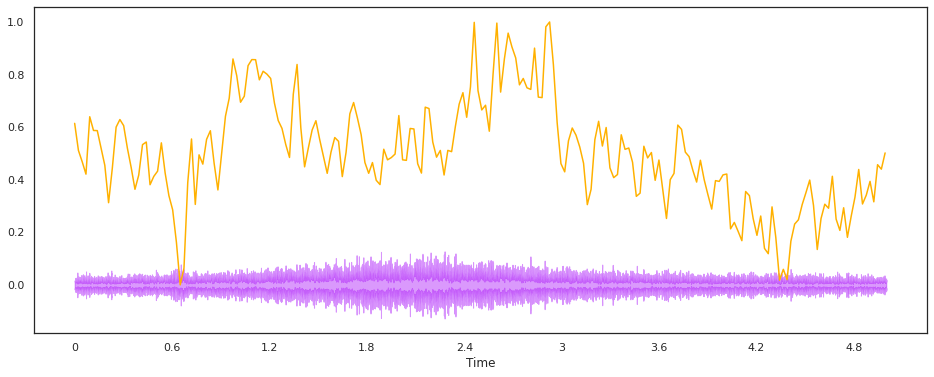

In [12]:
car_spectral_centroid = librosa.feature.spectral_centroid(car, sr=srCar)[0]

print("Spectral shape:" ,car_spectral_centroid.shape)

frames = range(len(car_spectral_centroid))

# Converts frame counts to time (seconds)
t = librosa.frames_to_time(frames)

#print('frames:', frames, '\n')
#print('t:', t)

# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

plt.figure(figsize = (16, 6))
librosa.display.waveshow(car, sr=srCar, alpha=0.4, color = '#A300F9');
plt.plot(t, normalize(car_spectral_centroid), color='#FFB100');

La oss prøve å sammenlige spectral centroid for de ulike kjøretøyene

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Pass y=[0.00226865 0.00776073 0.00591684 ... 0.01334683 0.01411158 0.01943225] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Pass y=[-0.00054459  0.00107558 -0.00248256 ...  0.01348502  0.01607826
  0.01400613] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Pass y=[-0.01548034 -0.02407063 -0.01515575 ...  0.03184409  0.01723798
  0.00210978] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Pass y=[ 0.01449251  0.03238819 -0.02465664 ... -0.03216054 -0.03199331
 -0.00997889] as keyword args. From version 0.10 passing thes

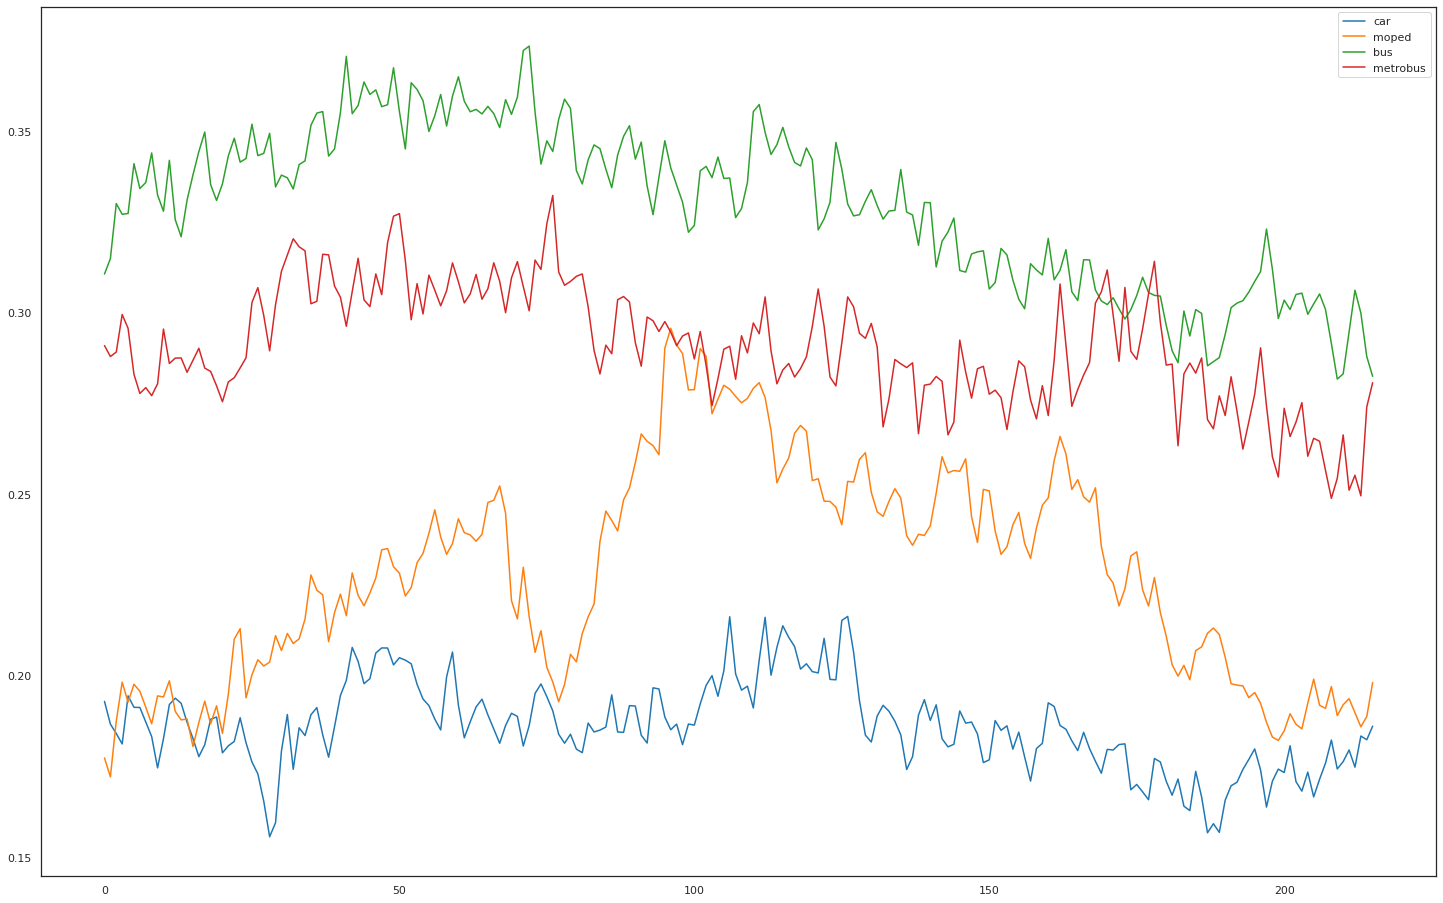

In [13]:
fig = plt.figure(figsize=(25,16))
i = 0
specs = []
color = ['#FFB100', "#84BA5B", "#7F8231", "#123FFF", "#BAC431"]
for sound in sound_samples:
        current_spec= librosa.feature.spectral_centroid(sound, sr=srCar)[0]
        frames = range(len(car_spectral_centroid))
        t = librosa.frames_to_time(frames)
        specs.append((current_spec) / (srCar/2))
        
df_specs = pd.DataFrame(specs).T
df_specs.head()
plt.plot(df_specs[0], label="car")
plt.plot(df_specs[1], label="moped")
plt.plot(df_specs[2], label="bus")
plt.plot(df_specs[3], label="metrobus")

plt.legend()
plt.show()



## MFCC
Basert på "Vehicle detection and classification from acoustic signal using ANN and KNN" kan man benytte denne featuren med gode resultater. På denne måten slipper man å analysere f.eks. et bilde av spektrogrammet elelr lydbølgen.


In [14]:
car_MFCC = librosa.feature.mfcc(car_trimmed, srCar)
print(car_MFCC.shape)


(20, 23)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Pass y=[0.06489989 0.04450801 0.03161936 ... 0.04234347 0.03601501 0.03156924], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  """Entry point for launching an IPython kernel.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Pass y=[0.00226865 0.00776073 0.00591684 ... 0.01334683 0.01411158 0.01943225] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Pass y=[-0.00054459  0.00107558 -0.00248256 ...  0.01348502  0.01607826
  0.01400613] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Pass y=[-0.01548034 -0.02407063 -0.01515575 ...  0.03184409  0.01723798
  0.00210978] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Pass y=

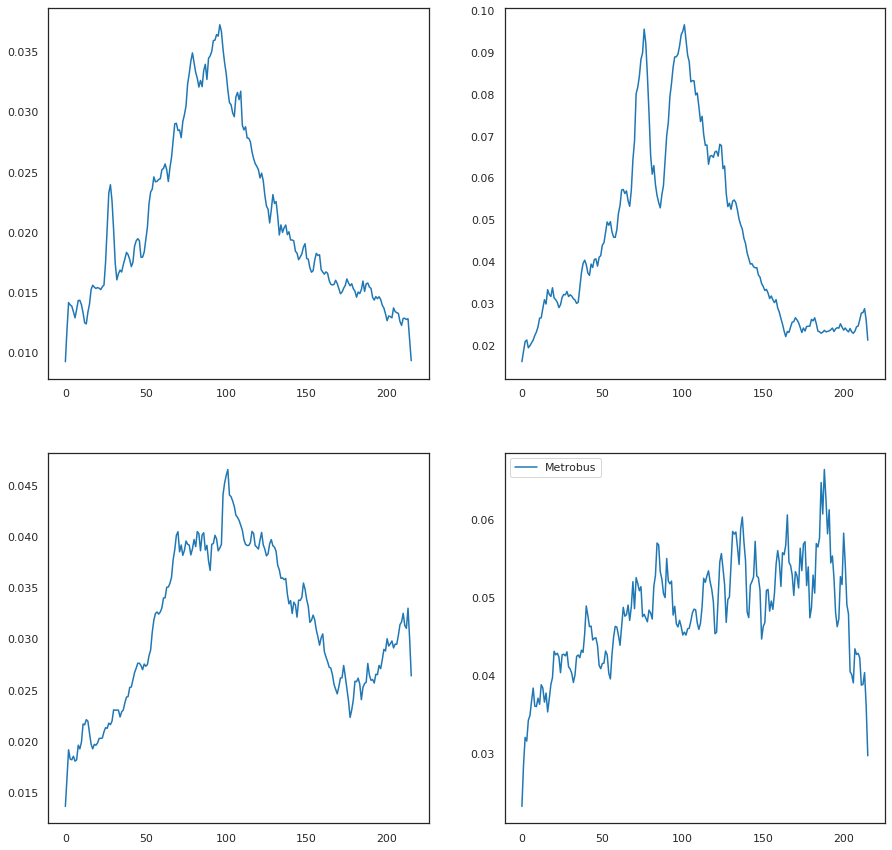

In [15]:
car_rms = librosa.feature.rms(car);
moped_rms = librosa.feature.rms(moped);
bus_rms= librosa.feature.rms(bus);
metrobus_rms = librosa.feature.rms(metroBus);
fig, axes = plt.subplots(2,2, figsize=(15,15));
axes[0][0].plot(car_rms[0], label = "Car");
axes[0][1].plot(moped_rms[0], label = "Moped");
axes[1][0].plot(bus_rms[0], label = "Bus");
axes[1][1].plot(metrobus_rms[0], label = "Metrobus");
plt.legend()
plt.show();
